In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import sqrt
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
%matplotlib inline
import time

In [3]:
train_df = pd.read_csv("train.csv", low_memory=False)
test_df = pd.read_csv("test.csv", low_memory=False)
data = pd.read_csv("data_set.csv", low_memory = False)

In [4]:
train_df = train_df[['id','precio']]
#train_df['precio'].value_counts()

In [5]:
print(data.shape)
print(test_df.shape)
print(train_df.shape)

(300000, 155)
(60000, 22)
(240000, 2)


In [6]:
features = pd.merge(train_df, data, on='id', how='inner')

In [7]:
features.not_outlier.value_counts()

1.0    215351
0.0     24649
Name: not_outlier, dtype: int64

In [8]:
type(features.loc[0].not_outlier)

numpy.float64

In [9]:
filter_name = 'not_outlier'
features = features[features[filter_name] == True]
features.shape
#features.not_outlier.value_counts()

(215351, 156)

In [10]:
features = features.fillna(0)

In [11]:
labels = features['precio']
features = features.drop(['id','precio'], axis=1)
features = features.drop(['Local en centro comercial', 'Local Comercial', 'desc_comedor', 'desc_frente', 'desc_transport', 'desc_amoblado', 'Nave industrial', 'Casa uso de suelo', 'Departamento Compartido', 'titulo_escuela', 'desc_ambientes', 'Huerta', 'titulo_avenida', 'desc_vende', 'Inmuebles productivos urbanos', 'titulo_zona', 'escuelascercanas', 'Quinta Vacacional', 'titulo_alquila', 'desc_auto', 'titulo_frente', 'desc_alquila', 'desc_anhelo', 'Villa', 'Otros', 'desc_zona', 'dia', 'mes', 'avenida', 'desc_avenida', 'desc_amenities_lujo', 'titulo_positiva', 'avenue_en_desc', 'titulo_anhelo', 'titulo_vende', 'titulo_amoblado', 'titulo_terminado', 'titulo_antiguedad', 'titulo_amenities_lujo', 'Desconocida', 'titulo_gym', 'titulo_auto', 'titulo_pago', 'Duplex', 'Lote', 'titulo_comedor', 'titulo_estudio', 'titulo_pileta', 'Garage', 'Hospedaje', 'titulo_transport', 'idzona_0'], axis=1)



In [12]:
features.shape

(215351, 102)

In [13]:
#prev:
#{'colsample_bytree': 0.7, 
#'learning_rate': 0.05, 
#'max_depth': 7, 
#'min_child_weight': 4, 
#'n_estimators': 500, 
#'nthread': 4, 
#'objective': 'reg:linear', 
#'silent': 1, 
#'subsample': 0.7}

#got with:
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}


#replace with current best:
parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [0.05], 
              'max_depth': [7, 8],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb = xgb.XGBRegressor(objective='reg:squarederror')

In [14]:
xgb_grid = GridSearchCV(xgb,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)


In [15]:
start_time = time.time()
xgb_grid.fit(features, labels)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   4 | elapsed:  9.9min finished
/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:squarederror',
                                    random_st...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=5,
             param_grid={'colsample_bytree': [0.7], 'learning_rate': [0.05],
                         'max_depth': [7, 8], 'min_child_weight': [4],
 

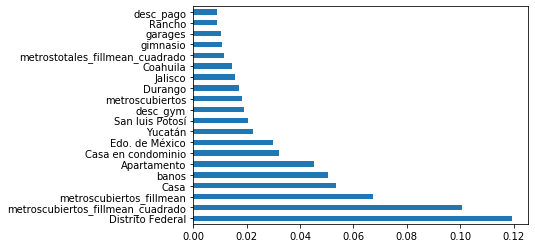

In [16]:
feat_importances = pd.Series(xgb_grid.best_estimator_.feature_importances_, index=features.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [17]:
df_feat_importances = pd.DataFrame(feat_importances).reset_index().rename(columns={'index':'feature',0:'importance'})
df_feat_importances = df_feat_importances.sort_values(by='importance',ascending=False)
df_feat_importances.to_csv('feature_importances_rob.csv',index=False)

In [18]:
print("--- %s seconds ---" % (time.time() - start_time))
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

--- 1327.1430649757385 seconds ---
0.8012450771647064
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [19]:
set_test = pd.merge(data, test_df[['id']],on = "id", how = "inner")
ids = set_test["id"]
set_test = set_test.drop(columns=['id'])
set_test = set_test.drop(['Local en centro comercial', 'Local Comercial', 'desc_comedor', 'desc_frente', 'desc_transport', 'desc_amoblado', 'Nave industrial', 'Casa uso de suelo', 'Departamento Compartido', 'titulo_escuela', 'desc_ambientes', 'Huerta', 'titulo_avenida', 'desc_vende', 'Inmuebles productivos urbanos', 'titulo_zona', 'escuelascercanas', 'Quinta Vacacional', 'titulo_alquila', 'desc_auto', 'titulo_frente', 'desc_alquila', 'desc_anhelo', 'Villa', 'Otros', 'desc_zona', 'dia', 'mes', 'avenida', 'desc_avenida', 'desc_amenities_lujo', 'titulo_positiva', 'avenue_en_desc', 'titulo_anhelo', 'titulo_vende', 'titulo_amoblado', 'titulo_terminado', 'titulo_antiguedad', 'titulo_amenities_lujo', 'Desconocida', 'titulo_gym', 'titulo_auto', 'titulo_pago', 'Duplex', 'Lote', 'titulo_comedor', 'titulo_estudio', 'titulo_pileta', 'Garage', 'Hospedaje', 'titulo_transport', 'idzona_0'], axis=1)


In [20]:
set_test = set_test.fillna(0)

In [21]:
set_test.head()

,habitaciones,banos,Apartamento,Bodega comercial,Casa,Casa en condominio,Edificio,Oficina comercial,Rancho,Terreno,...,Quintana Roo,San luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz,Yucatán,Zacatecas
0,3.0,4.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2.0,2.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,2.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
preds_kaggel_knn = xgb_grid.predict(set_test)

In [23]:
df_kaggel_knn = pd.DataFrame(preds_kaggel_knn)
df_kaggel_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 1 columns):
0    60000 non-null float32
dtypes: float32(1)
memory usage: 234.5 KB


In [24]:
df_kaggel_knn = pd.DataFrame(df_kaggel_knn)

In [25]:
df_kaggel_knn.head()

,0
0,4.464213e+06
1,1.092041e+06
2,2.434593e+06
3,1.216821e+06
4,6.850093e+05


In [26]:
# df_kaggel_knn = df_kaggel_knn.to_frame()# df_kagg 
df_kaggel_knn["id"] = ids
df_kaggel_knn.rename(columns = {0: 'target'},inplace = True) 
df_kaggel_knn = df_kaggel_knn[['id','target']]

In [27]:
df_kaggel_knn.head()

,id,target
0,4941,4.464213e+06
1,51775,1.092041e+06
2,115253,2.434593e+06
3,299321,1.216821e+06
4,173570,6.850093e+05


In [31]:
df_kaggel_knn.to_csv('ResultadosXGB_without_outliers.csv',index=False)

In [29]:
df_kaggel_knn.shape

(60000, 2)

In [30]:
df_kaggel_knn.head()

,id,target
0,4941,4.464213e+06
1,51775,1.092041e+06
2,115253,2.434593e+06
3,299321,1.216821e+06
4,173570,6.850093e+05
